<a href="https://colab.research.google.com/github/tiago121/e-commerce_customer_segmentation-/blob/main/Custumer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custumer Segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.0 Initial considerations

**Negócio:** marketplace online de produtos variados.

**Problema de negócio:** dificuldade com retenção de clientes.

**Dados:** transações no período de um ano.

**Solução:** Descobrir, por meio da clusterização, padrões nos clientes a fim de em fazer ofertas personalizadas para diferentes tipos de clientes, aumentando a frequência de compra e diminuindo o tempo de compra.


**Planejamento:**
- Olhar e limpar os dados
- Criar features que ajudem na análise
- Análisar os dados
- Testar modelos de redução de dimensionalidade e de clusterização
- Análisar os clusters e a estratégia de negócio



### 0.1 Imports

In [ ]:
import numpy   as np
import pandas  as pd
import seaborn as sns


from IPython.display import HTML
from matplotlib import pyplot as plt


from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx

from plotly import express as px



###0.2 Helper fuctions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.3 Load Data

In [ ]:
df_raw = pd.read_csv( '/content/drive/MyDrive/Datasets/data.csv', encoding= 'unicode_escape')

## 1.0 Data Description (Missing values, dtypes and format checks)

In [ ]:
df1 = df_raw.copy()

In [ ]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [ ]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


In [ ]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [ ]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [ ]:
len(df1['customer_id'].unique())

4373

### 1.1 Replacing missing values

In [ ]:
# customer_id

df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [ ]:
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 18288, 18288+len( df_backup ), 1)

In [ ]:
df_backup.head()

,invoice_no,customer_id
622,536414,18288
1443,536544,18289
1970,536545,18290
1971,536546,18291
1972,536547,18292


In [ ]:
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

# Droping description
df1 = df1.drop( columns='description', axis=1 )
df1.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,8,12/1/2010 8:26,2.75,United Kingdom,17850.0
3,536365,84029G,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
4,536365,84029E,6,12/1/2010 8:26,3.39,United Kingdom,17850.0


###1.2 Change Data Types

In [ ]:
# invoice date (ver se datetime está correto)
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'])
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'].dt.strftime( '%Y-%m-%d' ) )


# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,6,2010-12-01,3.39,United Kingdom,17850


In [ ]:
df1.dtypes

invoice_no              object
stock_code              object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

###1.3 Descriptive analysis

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.3.1 Numerical Attributes

In [ ]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,21997.0,9651.00,16511.362389,16249.00,2659.563055,0.375411,-0.834123


#### 1.3.2 Categorical Attributes

In [ ]:
#check letter_invoices (characters and numbers)
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )


Total number of invoices: 9291
Total number of negative quantity: 9288


Principais insights com descrição dos dados:

1. Coluna unit_price: alguns valores de unit_price são negativos, muito baixos ou muito altos (prováveis outliers)
2. Coluna invoice: contém algumas letras (o que já foi tratado acima)
3. Coluna description e stock code: não mostram nenhum padrão aparente (serão dropadas ao longo do projeto)
4. Coluna quantity: alguns valores negativos

A seguir será feita a filtragem dessas variáveis.


##2.0 Data Filtering

In [ ]:
df2 = df1.copy()

In [ ]:
# Numerical attributes 
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Drop outlier user
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity - split returns and purchases
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

In [ ]:
df2_purchases.shape

(530097, 7)

In [ ]:

print(df2_purchases['invoice_date'].max() - df2_purchases['invoice_date'].min())

373 days 00:00:00


##3.0 Feature Engineering

In [ ]:
df3 = df2_purchases.copy()

In [ ]:
df3.shape

(530097, 7)

In [ ]:
len(df3['customer_id'].unique())

5765

In [ ]:
df3.duplicated().sum()

5229

Foi criada uma nova base de dados apenas com clientes únicos, de modo que possamos agregar as informações por cliente.

In [ ]:
#data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )


In [ ]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### 3.1 Total quantity

In [ ]:

df_quantity = df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_quantity, on='customer_id', how='left' )
df_ref.rename(columns = {'quantity':'total_quantity'}, inplace = True)
df_ref['total_quantity'] = df_ref['total_quantity']


#### 3.2 Gross Revenue

In [ ]:
df_revenue = df2_purchases.loc[:, ['customer_id', 'unit_price']].groupby( 'customer_id' ).sum().reset_index() 
df_ref = pd.merge( df_ref, df_revenue, on='customer_id', how='left' )
df_ref.rename(columns = {'unit_price':'gross_revenue'}, inplace = True)


In [ ]:
df_ref = df_ref.dropna(subset=['gross_revenue', 'total_quantity'])
df_ref.isna().sum()


customer_id       0
total_quantity    0
gross_revenue     0
dtype: int64

In [ ]:
df_ref.dtypes

customer_id         int64
total_quantity      int64
gross_revenue     float64
dtype: object

####3.3 Recency

In [ ]:
df_invoice = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_invoice['recency'] = df2_purchases['invoice_date'].max() - df_invoice['invoice_date']
df_ref = pd.merge( df_ref, df_invoice, on='customer_id', how='left' )
df_ref.head()

,customer_id,total_quantity,gross_revenue,invoice_date,recency
0,17850,1733,1176.23,2010-12-02,372 days
1,13047,1391,676.31,2011-11-08,31 days
2,12583,5060,766.59,2011-12-07,2 days
3,13748,439,111.90,2011-09-05,95 days
4,15100,80,32.85,2011-01-10,333 days


In [ ]:
#Drop invoice_date
df_ref = df_ref.drop(columns =['invoice_date'], axis=1)

In [ ]:
df_ref.head()

,customer_id,total_quantity,gross_revenue,recency
0,17850,1733,1176.23,372 days
1,13047,1391,676.31,31 days
2,12583,5060,766.59,2 days
3,13748,439,111.90,95 days
4,15100,80,32.85,333 days


#### 3.4 Average ticket

In [ ]:
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'unit_price']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'unit_price':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
total_quantity    0
gross_revenue     0
recency           0
avg_ticket        0
dtype: int64

In [ ]:
df_ref.head(20)

,customer_id,total_quantity,gross_revenue,recency,avg_ticket
0,17850,1733,1176.23,372 days,3.960370
1,13047,1391,676.31,31 days,3.932035
2,12583,5060,766.59,2 days,3.103603
3,13748,439,111.90,95 days,3.996429
4,15100,80,32.85,333 days,10.950000
5,15291,2103,524.63,25 days,5.093495
6,14688,3621,696.85,7 days,2.131040
7,17809,2057,177.25,16 days,2.905738
8,15311,38194,5961.86,0 days,2.506036
9,16098,613,296.45,87 days,4.424627


In [ ]:
df_ref.shape

(5765, 5)

In [ ]:
df_ref['recency'] = df_ref['recency'].astype("str")

In [ ]:
df_ref['recency'] = df_ref['recency'].str.replace(r'[^0-9]', '')
df_ref.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,customer_id,total_quantity,gross_revenue,recency,avg_ticket
0,17850,1733,1176.23,372,3.960370
1,13047,1391,676.31,31,3.932035
2,12583,5060,766.59,2,3.103603
3,13748,439,111.90,95,3.996429
4,15100,80,32.85,333,10.950000


In [ ]:
df_ref['recency'] = df_ref['recency'].astype("int")
df_ref.dtypes

customer_id         int64
total_quantity      int64
gross_revenue     float64
recency             int64
avg_ticket        float64
dtype: object

####3.5 Frequency

In [ ]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
total_quantity    0
gross_revenue     0
recency           0
avg_ticket        0
frequency         0
dtype: int64

In [ ]:
df_ref.head()

,customer_id,total_quantity,gross_revenue,recency,avg_ticket,frequency
0,17850,1733,1176.23,372,3.960370,17.000000
1,13047,1391,676.31,31,3.932035,0.029155
2,12583,5060,766.59,2,3.103603,0.040323
3,13748,439,111.90,95,3.996429,0.017921
4,15100,80,32.85,333,10.950000,0.073171


## 4.0 EDA (Exploratory Data Analysis)

In [ ]:
df4 = df_ref.copy()

In [ ]:
df4  = df4.drop(['customer_id'],axis=1)
df4.head()

,total_quantity,gross_revenue,recency,avg_ticket,frequency
0,1733,1176.23,372,3.960370,17.000000
1,1391,676.31,31,3.932035,0.029155
2,5060,766.59,2,3.103603,0.040323
3,439,111.90,95,3.996429,0.017921
4,80,32.85,333,10.950000,0.073171


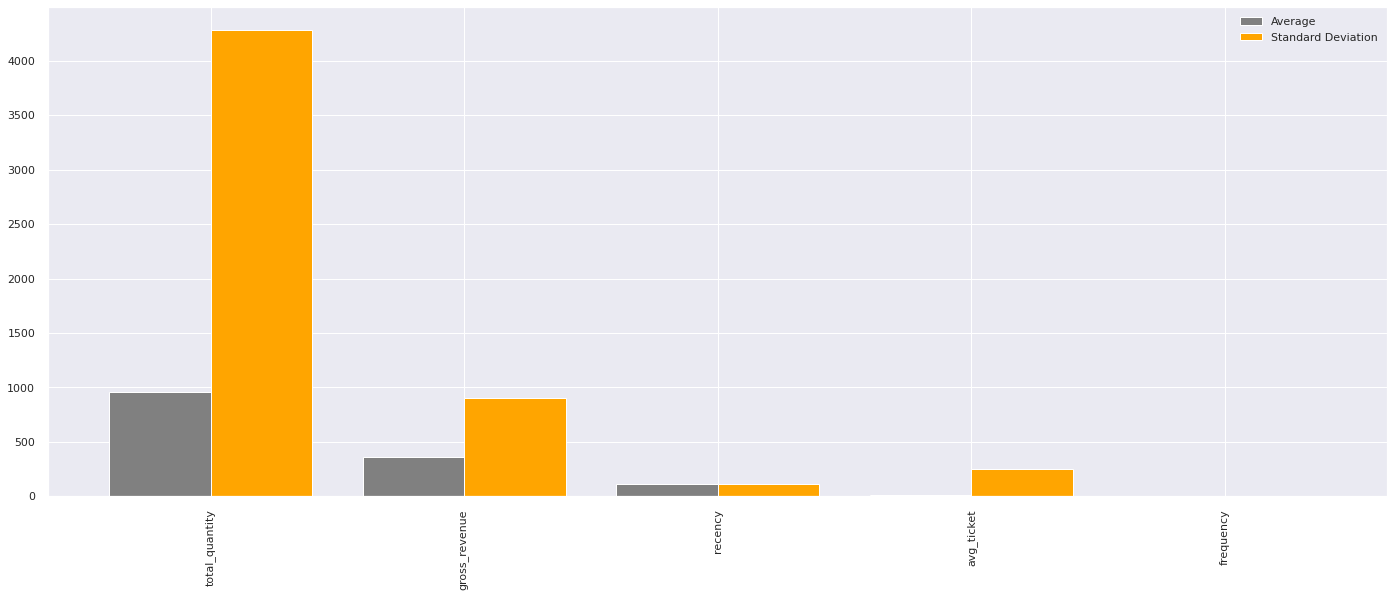

In [ ]:
df_plot = df4
averages = df_plot.mean() 
st_dev = df_plot.std()
x_names = df_plot.columns
x_ix = np.arange(df_plot.shape[1])
# Plot the data
import matplotlib.pyplot as plt
plt.bar(x_ix-0.2, averages, color='grey', label='Average', width=0.4)
plt.bar(x_ix+0.2, st_dev, color='orange', label='Standard Deviation', width=0.4)
plt.xticks(x_ix, x_names, rotation=90)
plt.legend()
plt.show()


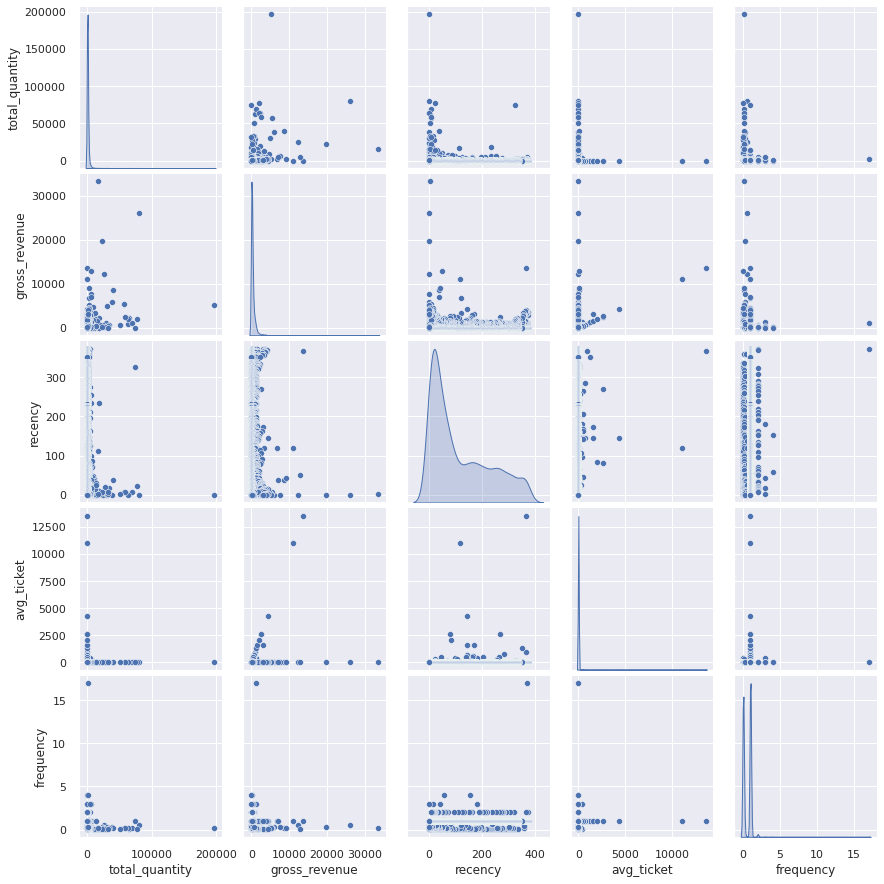

In [ ]:
import seaborn as snn
sns.pairplot(df4, diag_kind='kde')
plt.show()

Principais pontos da EDA: 

- Distribuição das variáveis não apresentam formato normal, com valores bem próximos de 0 e outliers (com exceção da recência)
- Frequency e avg_ticket e recência apresentam pouca variação
- Não há correlação significativa entre as variáveis

In [ ]:
df4.shape

(5765, 5)

##5.0 Pre-processing and dimensionality reduction

In [ ]:
df5 = df4.copy()

### 5.1 Reescaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df5)
df5_scaled = scaler.transform(df5)

df5  = pd.DataFrame(data= df5_scaled  , index=df5.index, columns=df5.columns)
print(df5.agg(['mean','std']).round())

      total_quantity  gross_revenue  recency  avg_ticket  frequency
mean             0.0            0.0      0.0         0.0        0.0
std              0.0            0.0      0.0         0.0        0.0


### 5.2 Dimensionality reduction

#### 5.2.1 PCA

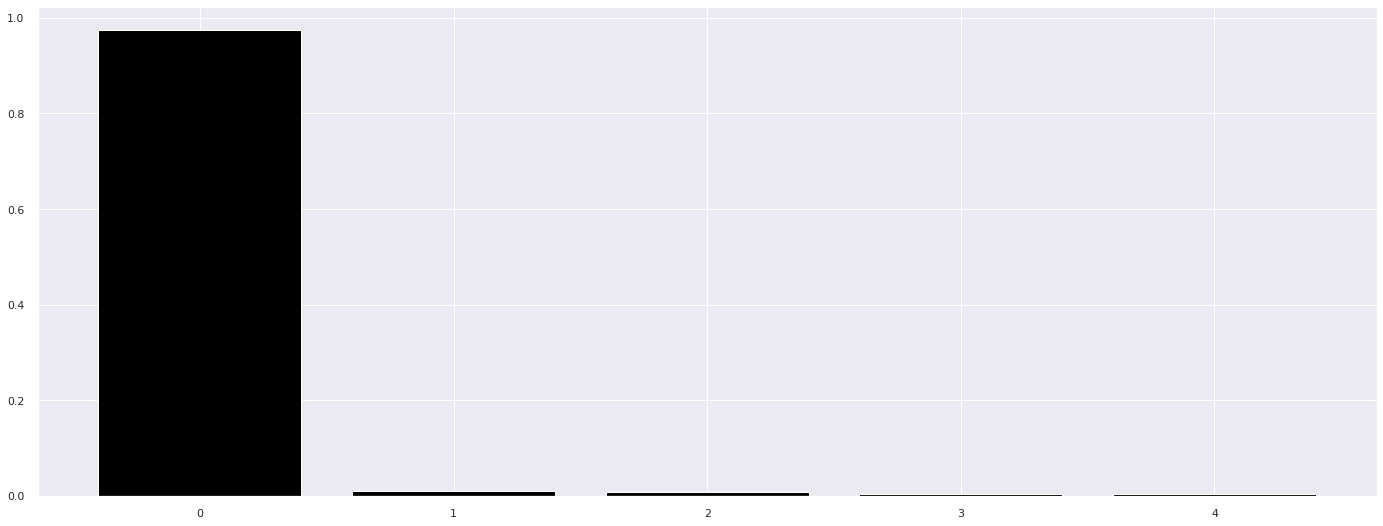

In [ ]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

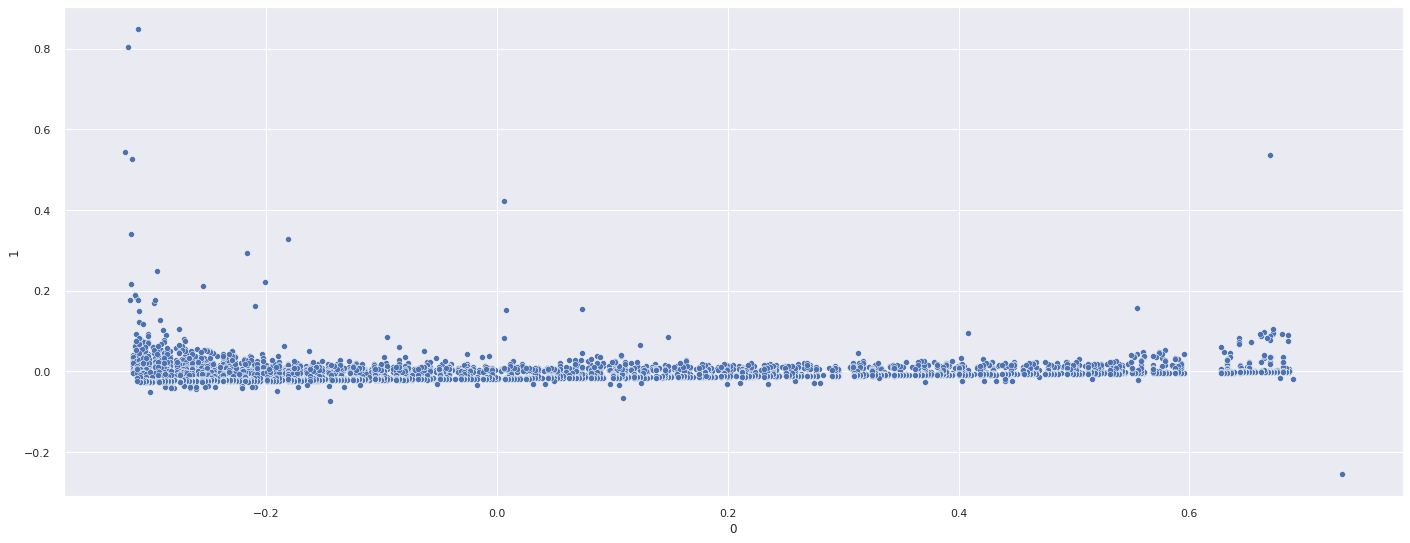

In [ ]:
sns.scatterplot( x=0, y=1, data=df_pca )

####5.2.2 UMAP

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=a2da26a5051d70a8b83906b951e025cb1ef8b0c406a2af534715f688695a4ffd
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=91f1b624e35e114fa3630d397a152c6734c324998706b675ef6d099182f9075c
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap

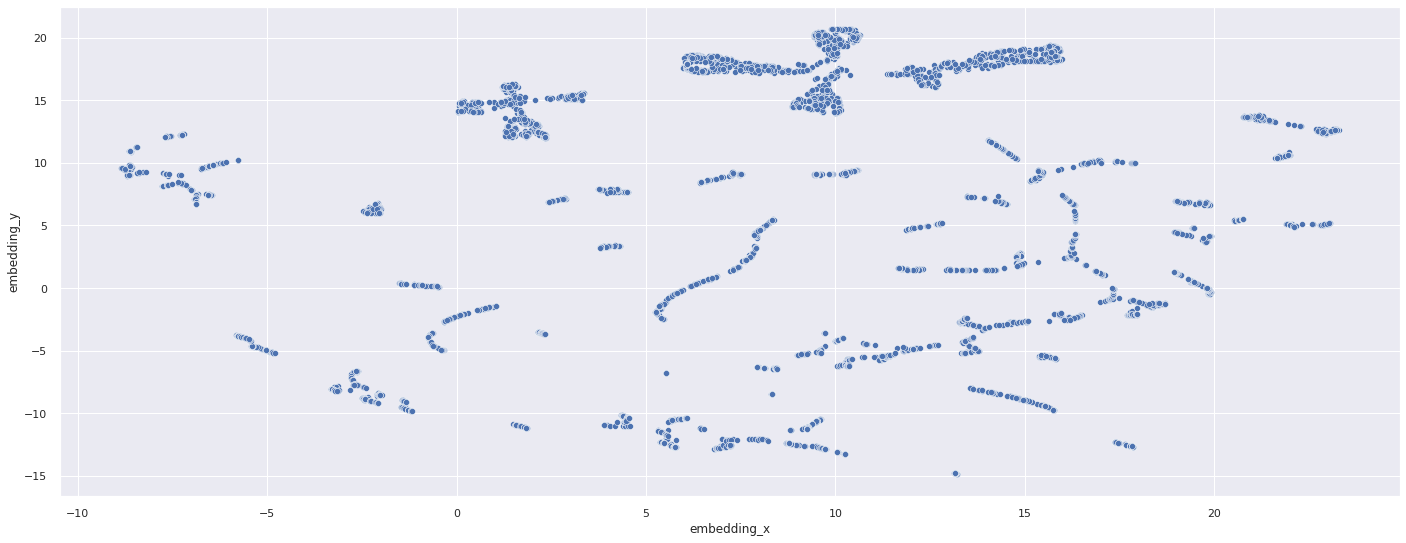

In [ ]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

####5.2.3 t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


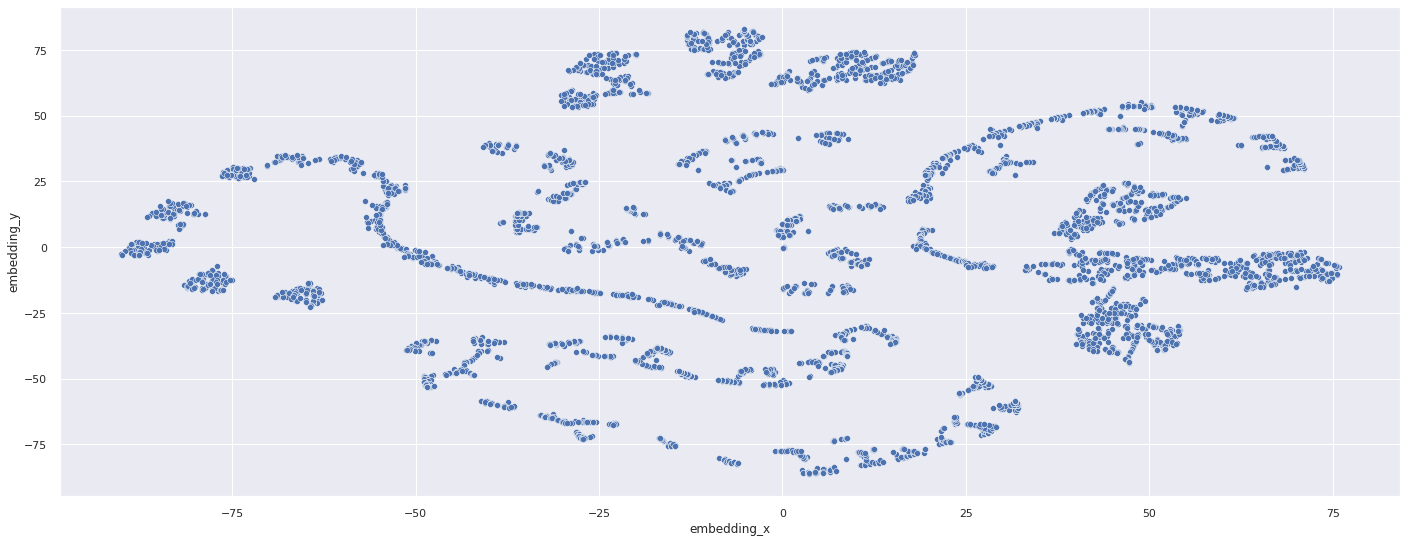

In [ ]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

####5.2.4 Tree-Based Embedding

In [ ]:
# training dataset
X = df5.drop( columns=['gross_revenue'], axis=1 )
y = df5['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 
df_leaf = pd.DataFrame( rf_model.apply( X ) )

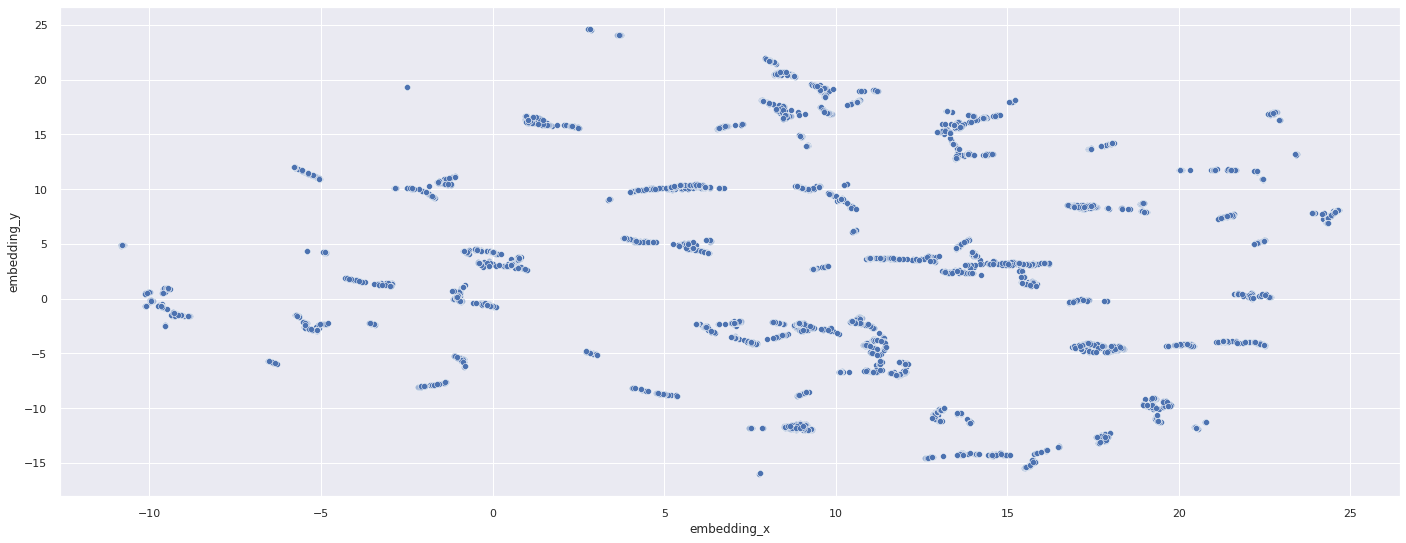

In [ ]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

##6. Cluster Algorithm Selection

Serão testados os 3 algoritmos de redução de dimensionalidade com os algoritmos de clusterização. Ao final foi escolhido o UMAP e o Kmeans, com 8 clusters por conseguir separar de forma mais clara o espaço de dados e atingir um bom número de silhouette score com 8 clusters (o esperado pelo negócio).

In [ ]:
# Tree-Based Embedding
#df5 = df_tree.copy()

# UMAP Embedding
df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()


In [ ]:
X = df5.copy()

###6.1 K-means

In [ ]:
clusters = np.arange( 2, 12, 1)
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state=42 )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

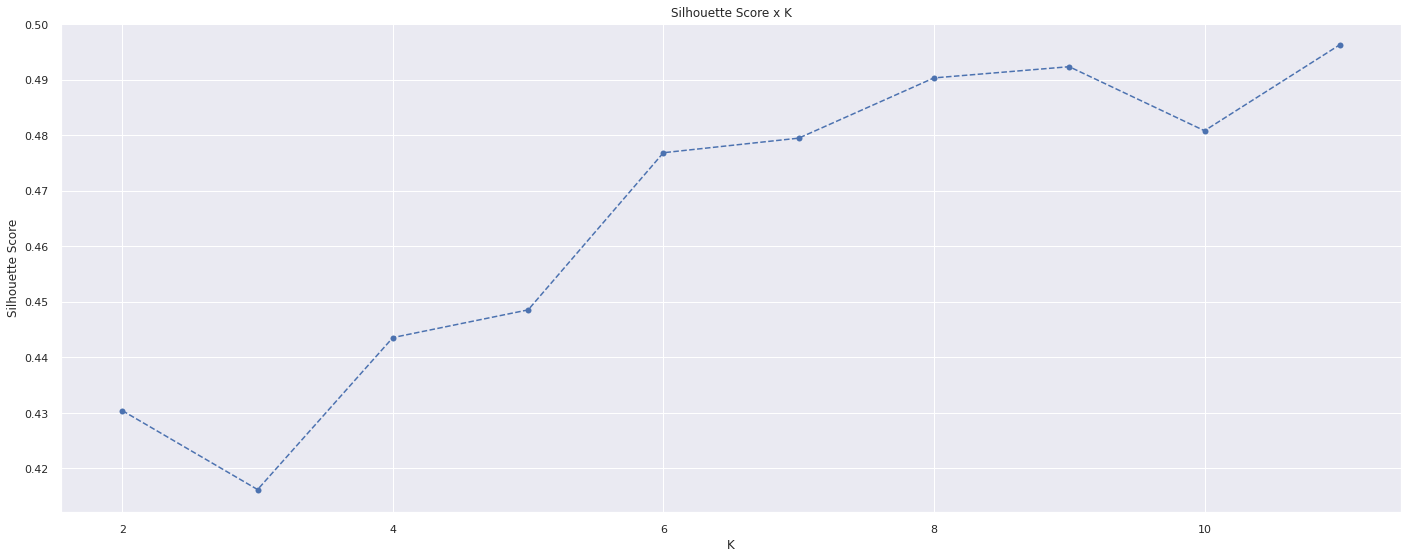

In [ ]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

###6.2 GMM (Gaussian mixture model)

In [ ]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=10, random_state=42 )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

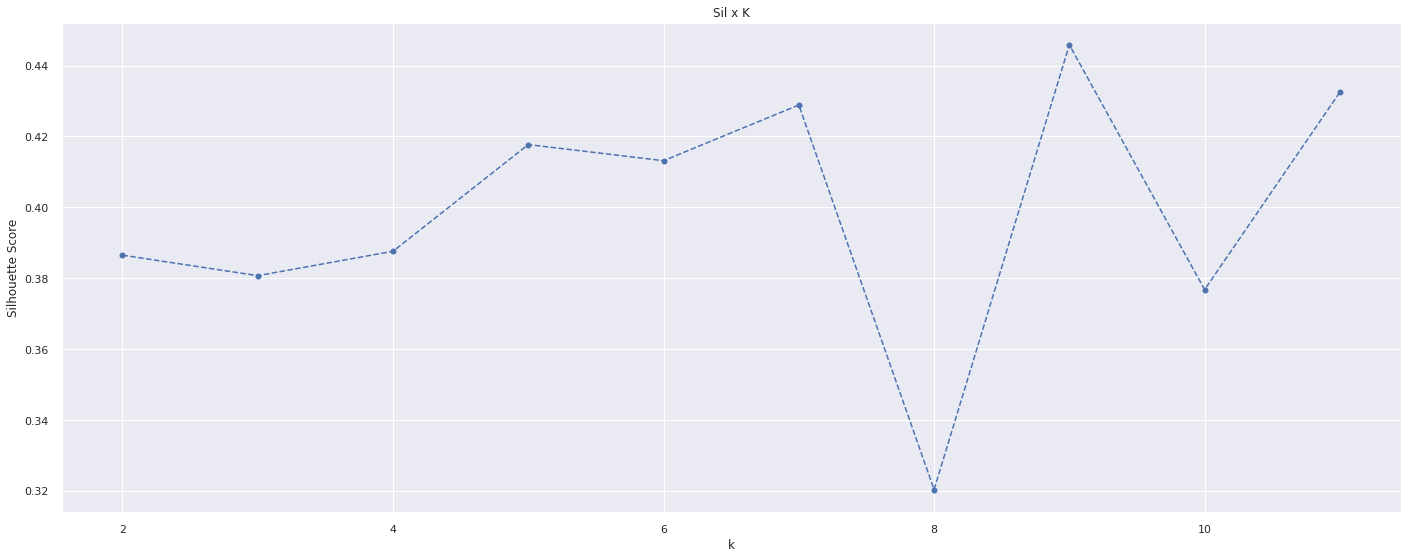

In [ ]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

###6.2 Hierarchical Clustering

In [ ]:
from scipy.cluster import hierarchy as hc

# model definition and training
hc_model = hc.linkage( X, 'ward' )

In [ ]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

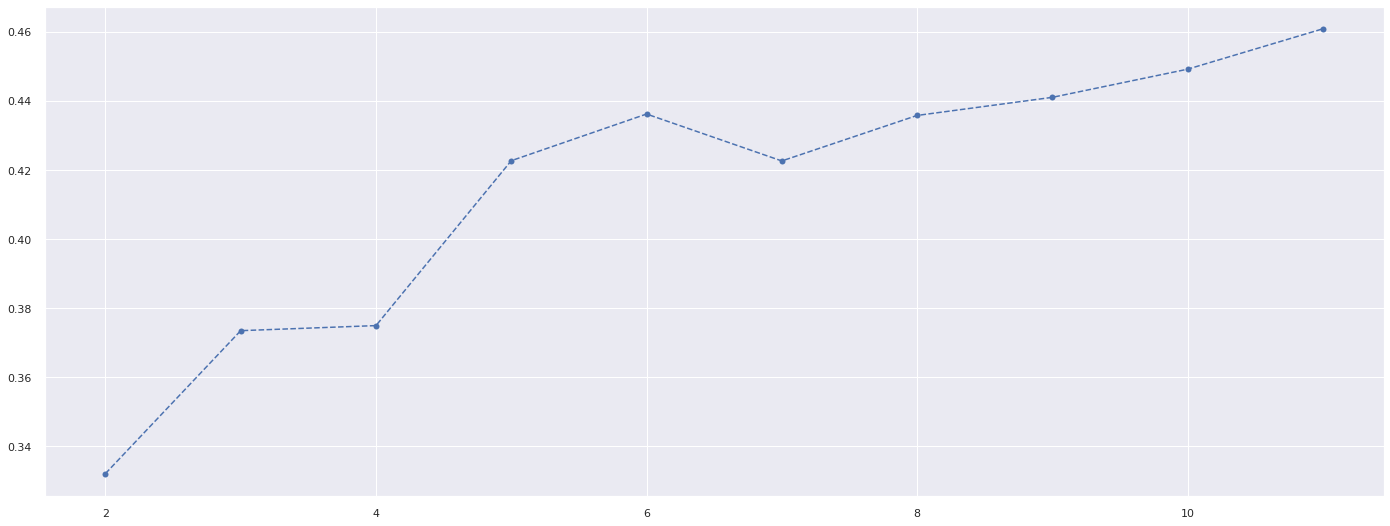

In [ ]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

In [ ]:
# ## Results - Tree Based Embedding

# df_results = pd.DataFrame( 
#     {'KMeans': kmeans_list, 
#      'GMM': gmm_list, 
#      'HC': hc_list}
# ).T

# df_results.columns = clusters
# df_results.style.highlight_max( color='lightgreen', axis=1 )

#            1          2        3          4         5        6         7         8          9        10
# KMeans	0.363151	0.418998	0.410383	0.407688	0.411782	0.430470	0.439965	0.474247	0.484309	0.491883
# GMM	    0.362217	0.361575	0.326939	0.309239	0.368468	0.397801	0.391553	0.429729	0.438231	0.432578	
# HC	    0.343437	0.377552	0.413780	0.402320	0.399353	0.420264	0.436464	0.442641	0.476442	0.483334

In [ ]:
# # Results - TSNE Embedding

# df_results = pd.DataFrame( 
#      {'KMeans': kmeans_list, 
#       'GMM': gmm_list, 
#       'HC': hc_list}
#  ).T

# df_results.columns = clusters
# df_results.style.highlight_max( color='lightgreen', axis=1 )
#            1          2        3          4         5        6         7         8          9        10
# KMeans	0.368112	0.384105	0.414354	0.400082	0.423824	0.432751	0.429154	0.426808	0.439894	0.442875
# GMM	    0.367626	0.375226	0.365805	0.366229	0.406510	0.325211	0.387168	0.315441	0.311543	0.324895
# HC	    0.304784	0.354009	0.386556	0.404955	0.419825	0.402162	0.398116	0.400321	0.397824	0.404581

In [ ]:
# # Results - UMAP Embedding

df_results = pd.DataFrame( 
     {'KMeans': kmeans_list, 
      'GMM': gmm_list, 
      'HC': hc_list}
 ).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )
#            1          2        3          4         5        6         7         8          9        10
# KMeans	0.430400	0.416183	0.443563	0.448554	0.476867	0.479492	0.490344	0.492365	0.480828	0.496310	
# GMM	    0.386494	0.380714	0.387594	0.417710	0.413155	0.428887	0.320341	0.445872	0.376774	0.432506	
# HC	    0.332063	0.373444	0.374913	0.422662	0.436180	0.422594	0.435769	0.441014	0.449164  0.460861

,2,3,4,5,6,7,8,9,10,11
KMeans,0.430400,0.416183,0.443563,0.448554,0.476867,0.479492,0.490344,0.492365,0.480828,0.496310
GMM,0.386494,0.380714,0.387594,0.417710,0.413155,0.428887,0.320341,0.445872,0.376774,0.432506
HC,0.332063,0.373444,0.374913,0.422662,0.436180,0.422594,0.435769,0.441014,0.449164,0.460861


## 7.0 Model Training

####7.1 Final Model

In [ ]:
# model definition
kmeans_model = c.KMeans( n_clusters=8, n_init=100, random_state=42 )

# model training
kmeans_model.fit( X )

# model predict
labels = kmeans_model.predict( X )

####7.2 Cluster Validation

In [ ]:
## WSS ( Within-cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.49034449458122253


##8.0 Cluster analysis

In [ ]:
df8 = X.copy()
df8['cluster'] = labels

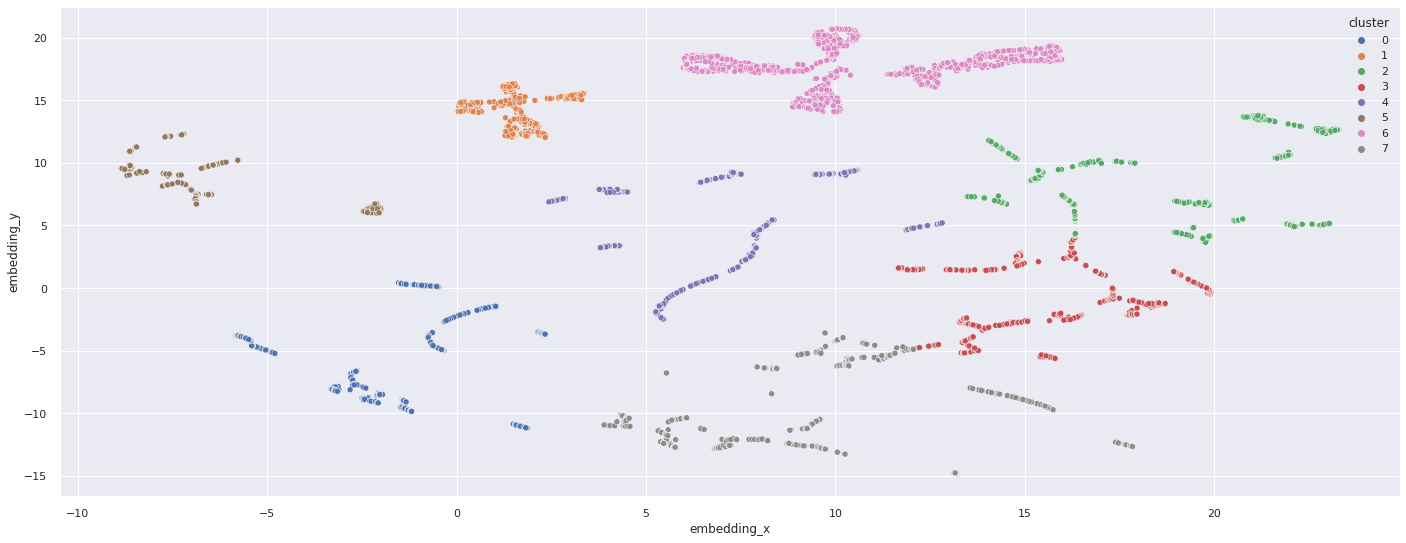

In [ ]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df8, palette='deep')

In [ ]:
df81 = df_ref.copy()
df81['cluster'] = labels
df81.head()

,customer_id,total_quantity,gross_revenue,recency,avg_ticket,frequency,cluster
0,17850,1733,1176.23,372,3.960370,17.000000,5
1,13047,1391,676.31,31,3.932035,0.029155,1
2,12583,5060,766.59,2,3.103603,0.040323,6
3,13748,439,111.90,95,3.996429,0.017921,4
4,15100,80,32.85,333,10.950000,0.073171,0


In [ ]:
# Number of customer
df_cluster = df81[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
#df_avg_gross_revenue = df81[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

df_avg_gross_revenue = df81[['gross_revenue', 'cluster']].groupby( 'cluster' ).median().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df81[['recency', 'cluster']].groupby( 'cluster' ).median().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Total_quantity
#df_qtde_products = df81[['total_quantity', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

df_qtde_products = df81[['total_quantity', 'cluster']].groupby( 'cluster' ).median().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df81[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )


df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency,total_quantity,frequency
6,6,1331,23.087598,297.580,10.0,986.0,0.044770
1,1,515,8.933218,218.300,37.0,710.0,0.031007
2,2,794,13.772767,93.915,56.5,280.0,0.760708
3,3,706,12.246314,87.500,143.0,126.5,1.014239
4,4,721,12.506505,85.060,81.0,281.0,0.526874
0,0,514,8.915872,83.245,304.0,142.0,0.758297
7,7,812,14.084996,80.585,240.0,124.5,0.885143
5,5,372,6.452732,76.385,358.0,126.0,0.793069


In [ ]:
# Number of customer
df_cluster = df81[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
#df_avg_gross_revenue = df81[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

df_avg_gross_revenue = df81[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df81[['recency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Total_quantity
#df_qtde_products = df81[['total_quantity', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

df_qtde_products = df81[['total_quantity', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df81[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )
df_cluster = df_cluster.drop(['customer_id'], axis=1)
df_cluster = df_cluster.sort_values( 'cluster')


In [ ]:
df_cluster

,cluster,perc_customer,gross_revenue,recency,total_quantity,frequency
0,0,8.915872,242.448833,288.466926,460.856031,0.758297
1,1,8.933218,323.409592,38.481553,1102.019417,0.031007
2,2,13.772767,389.989244,52.732997,506.375315,0.760708
3,3,12.246314,341.970793,139.201133,254.582153,1.014239
4,4,12.506505,139.258169,74.613037,501.503467,0.526874
5,5,6.452732,405.181962,285.712366,389.483871,0.793069
6,6,23.087598,583.078445,11.362134,2575.105184,0.044770
7,7,14.084996,248.737771,235.959360,230.567734,0.885143


In [ ]:
df_cluster['cluster'] = df_cluster['cluster'] + 1

In [ ]:
df_cluster

,cluster,perc_customer,gross_revenue,recency,total_quantity,frequency
0,3,8.915872,242.448833,288.466926,460.856031,0.758297
1,4,8.933218,323.409592,38.481553,1102.019417,0.031007
2,5,13.772767,389.989244,52.732997,506.375315,0.760708
3,6,12.246314,341.970793,139.201133,254.582153,1.014239
4,7,12.506505,139.258169,74.613037,501.503467,0.526874
5,8,6.452732,405.181962,285.712366,389.483871,0.793069
6,9,23.087598,583.078445,11.362134,2575.105184,0.044770
7,10,14.084996,248.737771,235.959360,230.567734,0.885143


### 8.1 Cluster Profile


Será usada tanto a média quanto a mediana para gerar informações em features com muita variação.

####  8 Clusters description

#### Cluster 1: 
- Número de customers: 9% dos clientes
- Recência média: 288 dias
- Média de Produtos comprados: 460 produtos
- Frequência de Produtos comprados: 0.76 produtos/dia
- Receita em média: $242.00 dólares
- **Estratégia:** enviar cupons de desconto com mais frequência para incentivar a fidelização e a diminuição da recência



#### Cluster 2:
- Número de customers:9% dos clientes 
- Recência média: 38 dias
- Média de Produtos comprados: 1102 produtos
- Frequência de Produtos comprados: 0.03 produtos/dia
- Receita em média: $323.00 dólares
- **Estratégia:** como é um grupo que compra em grande quantidade, mostrar anúncios de produtos semelhantes aos comprados por eles, a fim de incentivar compras mais variadas.

#### Cluster 3:
- Número de customers: 13% dos clientes 
- Recência média: 21 dias
- Média de Produtos comprados: 506 produtos
- Frequência de Produtos comprados: 0.76 produtos/dia
- Receita em média: $389.00 dólares
- **Estratégia:** por economia de recursos, não atuar com esse grupo por enquanto, monitorando o seu comportamento

#### Cluster 4:
- Número de customers: 12% dos clientes 
- Recência média: 53 dias
- Média de Produtos comprados: 254 produtos
- Frequência de Produtos comprados: 1 produtos/dia
- Receita em média: $341.00 dólares
- **Estratégia:** enviar cupons de desconto com mais frequência para incentivar a fidelização e a diminuição da recência

#### Cluster 5:
- Número de customers: 12% dos clientes 
- Recência média: 74 dias
- Média de Produtos comprados: 501 produtos
- Frequência de Produtos comprados: 0.5 produtos/dia
- Receita em média: $139.00 dólares
- **Estratégia:** fazer um teste A/B: dividir esse grupo aleatoriamente em 2, enviando e-mails com produtos mais caros para um e mais baratos para outro. O teste tem o objetivo de ver o efeito na recência e na mudança do ticket médio do cliente.

#### Cluster 6:
- Número de customers: 6% dos clientes
- Recência média: 285 dias
- Média de Produtos comprados: 389 produtos
- Frequência de Produtos comprados: 0.8 produtos/dia
- Receita em média: $405.00 dólares
- **Estratégia:** enviar cupons de desconto com mais frequência para incentivar a fidelização e a diminuição da recência

#### Cluster 7:
- Número de customers: 23% dos clientes
- Recência média: 11 dias
- Média de Produtos comprados: 2575 produtos
- Frequência de Produtos comprados: 0.04 produtos/dia
- Receita em média: $583.00 dólares
- **Estratégia:** criar um canal de antendimento especializado para esse grupo, a fim de incentivar a manutenção do comportamento de compra. 

#### Cluster 8:
- Número de customers: 14% dos clientes
- Recência média: 235 dias
- Média de Produtos comprados: 230 produtos
- Frequência de Produtos comprados: 0.9 produtos/dia
- Receita em média: $248.00 dólares
- **Estratégia:** enviar e-mails com produtos mais baratos a fim de estimular a compra mais frequente.

